# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 6 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. **Calculate lattice vectors**
5. Calculate strain
6. Visualize strain maps

# Notebook 4: Calculate lattice vectors

In this step the lattice vectors are calculated from the list of Bragg peaks, as follows:

* For one, typical diffraction pattern:
    * Get the list of Bragg peaks
    * Calculate the projection of the peak lists as a function of rotation, from 0 to 180 degrees
    * Find rotation angles that give the fewest, sharpest projected peaks
    * Get the lattice vectors
* Save the lattice vector list

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList

/Users/Ben/Code/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the raw data
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(60,60)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3 is not a py4DSTEM file.  Reading with hyperspy...


In [3]:
# # Load the raw data
# fp = "/home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
# dc = py4DSTEM.readwrite.read_data_v0_1(fp)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

In [4]:
# Load corrected Bragg peaks list
fp_Braggpeaks = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
browser.show_dataobjects()
Bragg_peaks = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    pointlist_0                         PointList           


In [5]:
# # Load corrected Bragg peaks list
# fp_Braggpeaks = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
# browser.show_dataobjects()
# Bragg_peaks = browser.get_dataobject(0)

### Get the list of Bragg peaks

In [6]:
# Select DP, get the Bragg peaks for this DP

rx,ry = 30,30
Bragg_peaks_current_DP = Bragg_peaks.get_subpointlist([('rx',rx),('ry',ry)])

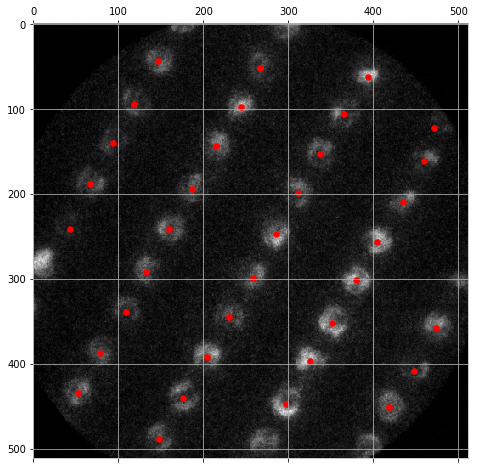

In [7]:
# Show

DP = dc.data4D[rx,ry,:,:]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
plt.show()

### Rotate, calculate projection, get projection maxima

In [8]:
# Get rotated coordinates

rotation_degrees = 30

theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

Bragg_peaks_rotated = Bragg_peaks_current_DP.deepcopy()

for i in range(Bragg_peaks_current_DP.length):
    x0 = Bragg_peaks_current_DP.data['qx'][i]
    y0 = Bragg_peaks_current_DP.data['qy'][i]
    Bragg_peaks_rotated.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotated.data['qy'][i] = x0*sintheta + y0*costheta

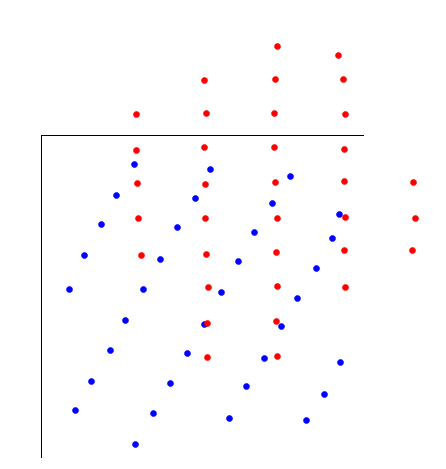

In [9]:
# Show

axis=np.ones_like(DP)
axis[0,:]=0
axis[:,0]=0

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(axis)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='b')
ax.scatter(Bragg_peaks_rotated.data['qy'],Bragg_peaks_rotated.data['qx'],color='r')
ax.axis('off')
plt.show()

In [10]:
# Calculate projected histograms

sigma_gaussianblur = 10

bins_x = np.arange(-dc.Q_Nx,dc.Q_Nx)
bins_y = np.arange(-dc.Q_Nx,dc.Q_Ny)
x_projected_histogram = np.zeros_like(bins_x)
y_projected_histogram = np.zeros_like(bins_y)
for i in range(Bragg_peaks_rotated.length):
    x_projected_histogram[int(Bragg_peaks_rotated.data['qx'][i])] += 1
    y_projected_histogram[int(Bragg_peaks_rotated.data['qy'][i])] += 1

x_histogram_blurred = gaussian_filter(x_projected_histogram.astype(float),sigma_gaussianblur)
y_histogram_blurred = gaussian_filter(y_projected_histogram.astype(float),sigma_gaussianblur)

In [11]:
# Get histogram maxima

min_dist = 10

x_maxima0 = (x_histogram_blurred > np.roll(x_histogram_blurred,-1)) & (x_histogram_blurred >= np.roll(x_histogram_blurred,+1))
y_maxima0 = (y_histogram_blurred > np.roll(y_histogram_blurred,-1)) & (y_histogram_blurred >= np.roll(y_histogram_blurred,+1))

coordinates = [('bin',int),('intensity',float)]
x_maxima = PointList(coordinates, dc)
y_maxima = PointList(coordinates, dc)

for i in x_maxima0.nonzero()[0]:
    new_point = (bins_x[i], x_histogram_blurred[i])
    x_maxima.add_point(new_point)
for i in y_maxima0.nonzero()[0]:
    new_point = (bins_y[i], y_histogram_blurred[i])
    y_maxima.add_point(new_point)

x_maxima.sort('intensity')
y_maxima.sort('intensity')

x_deletemask = np.zeros(x_maxima.length,dtype=bool)
for i in range(x_maxima.length):
    if not x_deletemask[i]:
        delete = np.abs(x_maxima.data['bin'][i]-x_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        x_deletemask = x_deletemask | delete
x_maxima.remove_points(x_deletemask)

y_deletemask = np.zeros(y_maxima.length,dtype=bool)
for i in range(y_maxima.length):
    if not y_deletemask[i]:
        delete = np.abs(y_maxima.data['bin'][i]-y_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        y_deletemask = y_deletemask | delete
y_maxima.remove_points(y_deletemask)


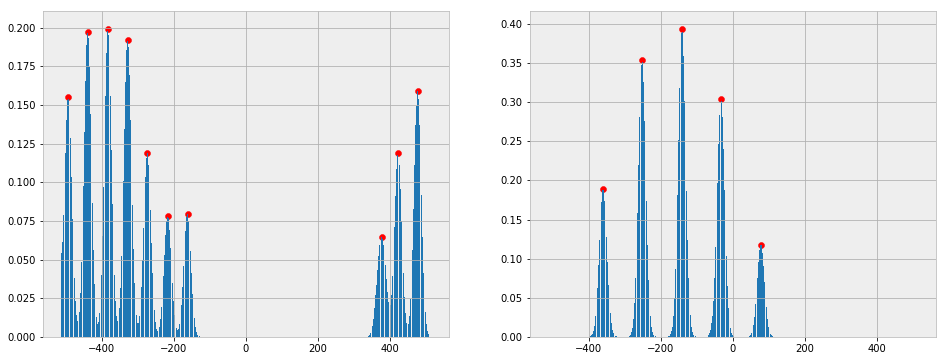

In [12]:
# Plot histograms

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.bar(bins_x, x_histogram_blurred)
ax1.scatter(x_maxima.data['bin'],x_maxima.data['intensity'],color='r')
ax2.bar(bins_y, y_histogram_blurred)
ax2.scatter(y_maxima.data['bin'],y_maxima.data['intensity'],color='r')
plt.show()

### Calculate the projection of the peaks as a function of rotation, from 0 to 180 degrees

In [13]:
# As a function of rotation angle, find number and intensity of histogram maxima

sigma_gaussianblur = 10
min_dist = 10
N_rotations = 100
threshhold = 0.05

# Rotating peaks list
Bragg_peaks_rotating = Bragg_peaks_current_DP.deepcopy()
rotation_degrees = 180./N_rotations
angles = np.linspace(0,180,N_rotations,endpoint=False)
theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

# Metrics
x_N_maxima = np.empty_like(angles)
y_N_maxima = np.empty_like(angles)
x_total_intensity = np.empty_like(angles)
y_total_intensity = np.empty_like(angles)

for j in range(len(angles)):
    angle = angles[j]
    
    # Rotate peaks
    for i in range(Bragg_peaks_rotating.length):
        x0 = Bragg_peaks_rotating.data['qx'][i]
        y0 = Bragg_peaks_rotating.data['qy'][i]
        Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
        Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
    # Get projected histogram
    bins_x = np.arange(-dc.Q_Nx,dc.Q_Nx)
    bins_y = np.arange(-dc.Q_Nx,dc.Q_Ny)
    x_projected_histogram = np.zeros_like(bins_x)
    y_projected_histogram = np.zeros_like(bins_y)
    for i in range(Bragg_peaks_rotating.length):
        x_projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
        y_projected_histogram[int(Bragg_peaks_rotating.data['qy'][i])] += 1
        
    x_histogram_blurred = gaussian_filter(x_projected_histogram.astype(float),sigma_gaussianblur)
    y_histogram_blurred = gaussian_filter(y_projected_histogram.astype(float),sigma_gaussianblur)
    
    # Get maxima
    x_maxima0 = (x_histogram_blurred > np.roll(x_histogram_blurred,-1)) & (x_histogram_blurred >= np.roll(x_histogram_blurred,+1))
    y_maxima0 = (y_histogram_blurred > np.roll(y_histogram_blurred,-1)) & (y_histogram_blurred >= np.roll(y_histogram_blurred,+1))
    
    coordinates = [('angle',float),('bin',int),('intensity',float)]
    x_maxima = PointList(coordinates, dc)
    y_maxima = PointList(coordinates, dc)
 
    for i in x_maxima0.nonzero()[0]:
        new_point = (angle, bins_x[i], x_histogram_blurred[i])
        x_maxima.add_point(new_point)
    for i in y_maxima0.nonzero()[0]:
        new_point = (angle, bins_y[i], y_histogram_blurred[i])
        y_maxima.add_point(new_point)
        
    x_maxima.sort('intensity')
    y_maxima.sort('intensity')

    # Remove maxima below threshhold
    max_intensity = x_maxima.data['intensity'][0]
    x_deletemask = np.zeros(x_maxima.length,dtype=bool)
    for i in range(x_maxima.length):
        if x_maxima.data['intensity'][i]/max_intensity < threshhold:
            x_deletemask[i] = True
    x_maxima.remove_points(x_deletemask)
    
    max_intensity = y_maxima.data['intensity'][0]
    y_deletemask = np.zeros(y_maxima.length,dtype=bool)
    for i in range(y_maxima.length):
        if y_maxima.data['intensity'][i]/max_intensity < threshhold:
            y_deletemask[i] = True
    y_maxima.remove_points(y_deletemask)
    
    # Remove maxima which are too close together
    x_deletemask = np.zeros(x_maxima.length,dtype=bool)
    for i in range(x_maxima.length):
        if not x_deletemask[i]:
            delete = np.abs(x_maxima.data['bin'][i]-x_maxima.data['bin']) < min_dist
            delete[:i+1]=False
            x_deletemask = x_deletemask | delete
    x_maxima.remove_points(x_deletemask)

    y_deletemask = np.zeros(y_maxima.length,dtype=bool)
    for i in range(y_maxima.length):
        if not y_deletemask[i]:
            delete = np.abs(y_maxima.data['bin'][i]-y_maxima.data['bin']) < min_dist
            delete[:i+1]=False
            y_deletemask = y_deletemask | delete
    y_maxima.remove_points(y_deletemask)
    
    # Calculat metrics
    x_N_maxima[j] = x_maxima.length
    y_N_maxima[j] = y_maxima.length
    x_total_intensity[j] = np.sum(x_maxima.data['intensity'])
    y_total_intensity[j] = np.sum(y_maxima.data['intensity'])
    
    x_maxima=None
    y_maxima=None
    collect()

### Find rotation angles that give the fewest, sharpest projected peaks

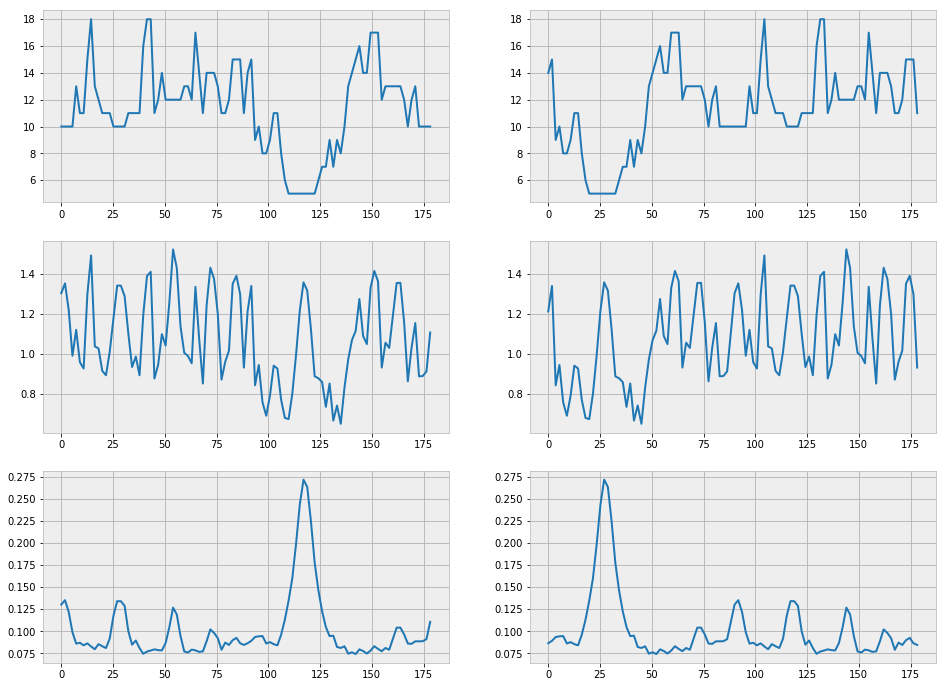

In [14]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

x_score = x_total_intensity/x_N_maxima
y_score = y_total_intensity/y_N_maxima

fig,((ax11,ax12),(ax21,ax22),(ax31,ax32))=plt.subplots(3,2,figsize=(16,12))
ax11.plot(angles,x_N_maxima)
ax21.plot(angles,x_total_intensity)
ax31.plot(angles,x_score)
ax12.plot(angles,y_N_maxima)
ax22.plot(angles,y_total_intensity)
ax32.plot(angles,y_score)
plt.show()

In [15]:
# Get maxima of scores

sigma = 2
min_diff = 5

x_score_blurred = gaussian_filter(x_score,sigma)
y_score_blurred = gaussian_filter(y_score,sigma)

x_maxima0 = (x_score_blurred > np.roll(x_score_blurred,-1)) & (x_score_blurred >= np.roll(x_score_blurred,+1))
y_maxima0 = (y_score_blurred > np.roll(y_score_blurred,-1)) & (y_score_blurred >= np.roll(y_score_blurred,+1))

coordinates = [('angle',float),('intensity',float)]
x_maxima = PointList(coordinates, dc)
y_maxima = PointList(coordinates, dc)

for i in x_maxima0.nonzero()[0]:
    new_point = (angles[i], x_score_blurred[i])
    x_maxima.add_point(new_point)
for i in y_maxima0.nonzero()[0]:
    new_point = (angles[i], y_score_blurred[i])
    y_maxima.add_point(new_point)

x_maxima.sort('intensity')
y_maxima.sort('intensity')

x_deletemask = np.zeros(x_maxima.length,dtype=bool)
for i in range(x_maxima.length):
    if not x_deletemask[i]:
        delete = np.abs(x_maxima.data['angle'][i]-x_maxima.data['angle']) < min_diff
        delete[:i+1]=False
        x_deletemask = x_deletemask | delete
x_maxima.remove_points(x_deletemask)

y_deletemask = np.zeros(y_maxima.length,dtype=bool)
for i in range(y_maxima.length):
    if not y_deletemask[i]:
        delete = np.abs(y_maxima.data['angle'][i]-y_maxima.data['angle']) < min_diff
        delete[:i+1]=False
        y_deletemask = y_deletemask | delete
y_maxima.remove_points(y_deletemask)

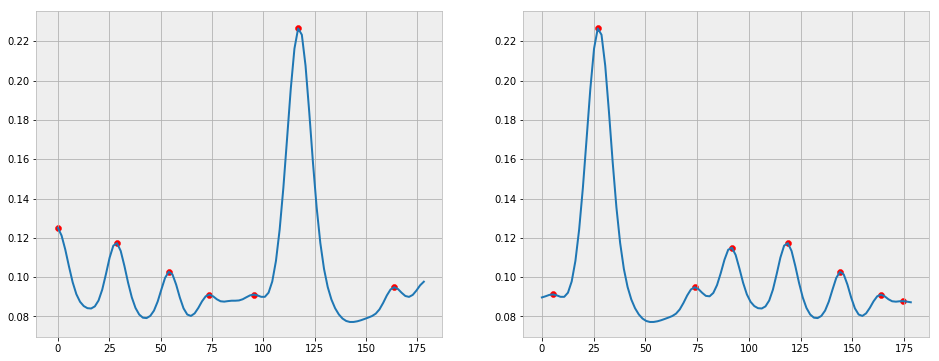

In [16]:
# Plot score and maxima

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.plot(angles, x_score_blurred)
ax1.scatter(x_maxima.data['angle'],x_maxima.data['intensity'],color='r')
ax2.plot(angles, y_score_blurred)
ax2.scatter(y_maxima.data['angle'],y_maxima.data['intensity'],color='r')
plt.show()

### Refinement

In [17]:
# Refine the three brightest maxima

# Params for refinement angles
window_rad_degrees = 8
N_rotations = 50

# Params for histograms
sigma_gaussianblur = 10
min_dist = 10
threshhold = 0.05

angles = np.linspace(-window_rad_degrees,window_rad_degrees,N_rotations)
rotation_degrees = 2*window_rad_degrees/N_rotations
theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

x_maxima.sort('intensity')
angle_guesses = x_maxima.data['angle'][0:3]

# Metrics
x_N_maxima = np.empty((len(angles),len(angle_guesses)))
y_N_maxima = np.empty((len(angles),len(angle_guesses)))
x_total_intensity = np.empty((len(angles),len(angle_guesses)))
y_total_intensity = np.empty((len(angles),len(angle_guesses)))

for k in range(len(angle_guesses)):
    
    angle_guess = angle_guesses[k]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)
    
    # Initial rotation
    Bragg_peaks_rotating = Bragg_peaks_current_DP.deepcopy()
    theta_i = angles[0]*np.pi/180.
    costheta_i = np.cos(theta_i)
    sintheta_i = np.sin(theta_i)
    for i in range(Bragg_peaks_rotating.length):
        x0 = Bragg_peaks_rotating.data['qx'][i]
        y0 = Bragg_peaks_rotating.data['qy'][i]
        Bragg_peaks_rotating.data['qx'][i] = x0*costheta_i - y0*sintheta_i
        Bragg_peaks_rotating.data['qy'][i] = x0*sintheta_i + y0*costheta_i
    
    for j in range(len(angles)):
        angle = angles[j]

        # Rotate peaks
        for i in range(Bragg_peaks_rotating.length):
            x0 = Bragg_peaks_rotating.data['qx'][i]
            y0 = Bragg_peaks_rotating.data['qy'][i]
            Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
            Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta

        # Get projected histogram
        bins_x = np.arange(-dc.Q_Nx,dc.Q_Nx)
        bins_y = np.arange(-dc.Q_Nx,dc.Q_Ny)
        x_projected_histogram = np.zeros_like(bins_x)
        y_projected_histogram = np.zeros_like(bins_y)
        for i in range(Bragg_peaks_rotating.length):
            x_projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
            y_projected_histogram[int(Bragg_peaks_rotating.data['qy'][i])] += 1

        x_histogram_blurred = gaussian_filter(x_projected_histogram.astype(float),sigma_gaussianblur)
        y_histogram_blurred = gaussian_filter(y_projected_histogram.astype(float),sigma_gaussianblur)

        # Get maxima
        x_maxima0 = (x_histogram_blurred > np.roll(x_histogram_blurred,-1)) & (x_histogram_blurred >= np.roll(x_histogram_blurred,+1))
        y_maxima0 = (y_histogram_blurred > np.roll(y_histogram_blurred,-1)) & (y_histogram_blurred >= np.roll(y_histogram_blurred,+1))

        coordinates = [('angle',float),('bin',int),('intensity',float)]
        x_maxima = PointList(coordinates, dc)
        y_maxima = PointList(coordinates, dc)

        for i in x_maxima0.nonzero()[0]:
            new_point = (angle, bins_x[i], x_histogram_blurred[i])
            x_maxima.add_point(new_point)
        for i in y_maxima0.nonzero()[0]:
            new_point = (angle, bins_y[i], y_histogram_blurred[i])
            y_maxima.add_point(new_point)

        x_maxima.sort('intensity')
        y_maxima.sort('intensity')

        # Remove maxima below threshhold
        max_intensity = x_maxima.data['intensity'][0]
        x_deletemask = np.zeros(x_maxima.length,dtype=bool)
        for i in range(x_maxima.length):
            if x_maxima.data['intensity'][i]/max_intensity < threshhold:
                x_deletemask[i] = True
        x_maxima.remove_points(x_deletemask)

        max_intensity = y_maxima.data['intensity'][0]
        y_deletemask = np.zeros(y_maxima.length,dtype=bool)
        for i in range(y_maxima.length):
            if y_maxima.data['intensity'][i]/max_intensity < threshhold:
                y_deletemask[i] = True
        y_maxima.remove_points(y_deletemask)

        # Remove maxima which are too close together
        x_deletemask = np.zeros(x_maxima.length,dtype=bool)
        for i in range(x_maxima.length):
            if not x_deletemask[i]:
                delete = np.abs(x_maxima.data['bin'][i]-x_maxima.data['bin']) < min_dist
                delete[:i+1]=False
                x_deletemask = x_deletemask | delete
        x_maxima.remove_points(x_deletemask)

        y_deletemask = np.zeros(y_maxima.length,dtype=bool)
        for i in range(y_maxima.length):
            if not y_deletemask[i]:
                delete = np.abs(y_maxima.data['bin'][i]-y_maxima.data['bin']) < min_dist
                delete[:i+1]=False
                y_deletemask = y_deletemask | delete
        y_maxima.remove_points(y_deletemask)

        # Calculat metrics
        x_N_maxima[j][k] = x_maxima.length
        y_N_maxima[j][k] = y_maxima.length
        x_total_intensity[j][k] = np.sum(x_maxima.data['intensity'])
        y_total_intensity[j][k] = np.sum(y_maxima.data['intensity'])

        x_maxima=None
        y_maxima=None
        collect()

Angle = 117.0


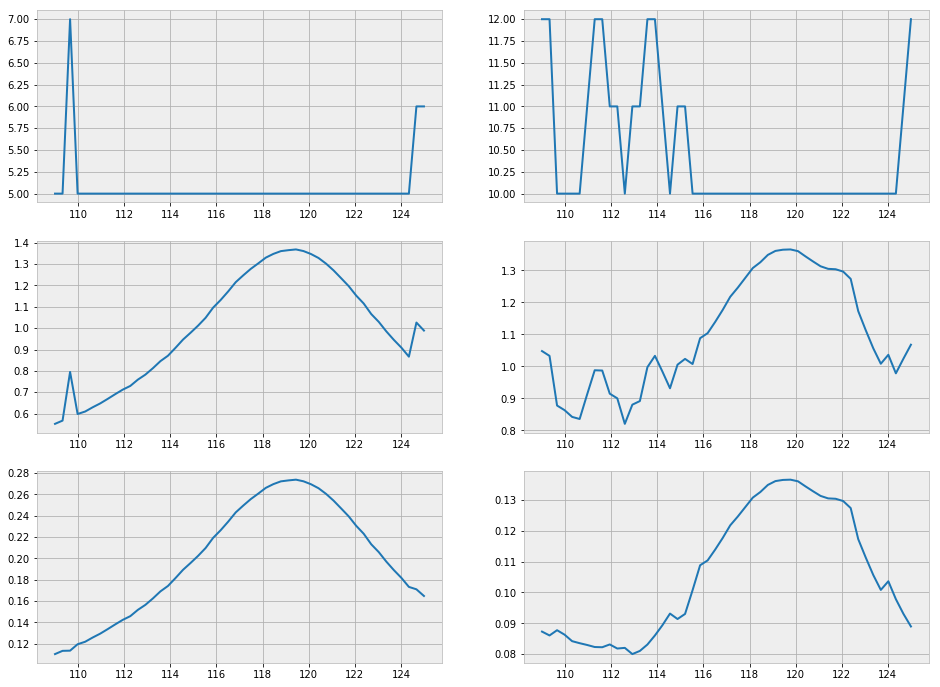

Angle = 0.0


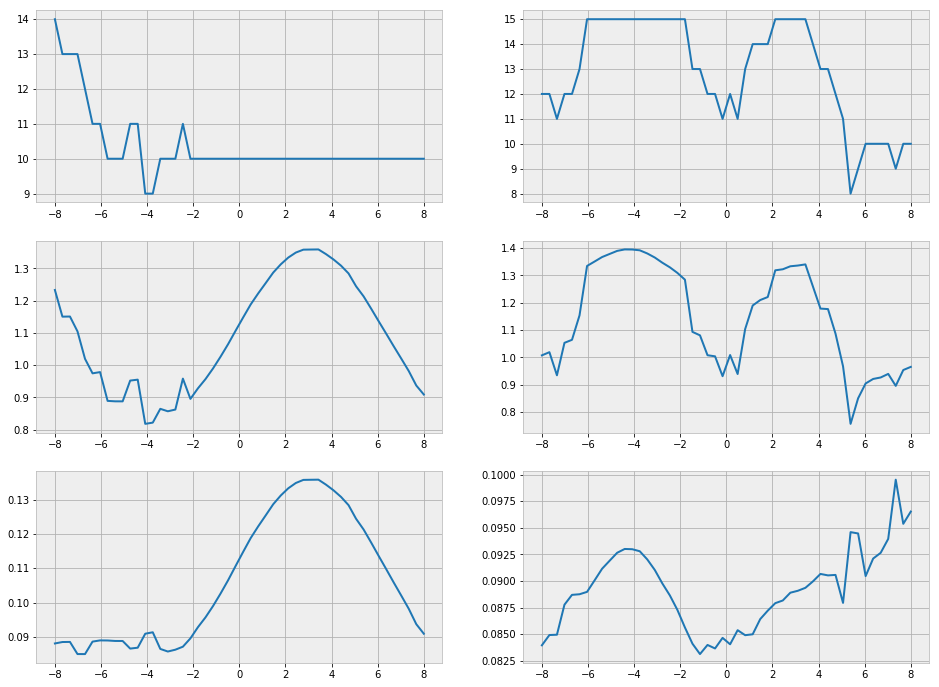

Angle = 28.8


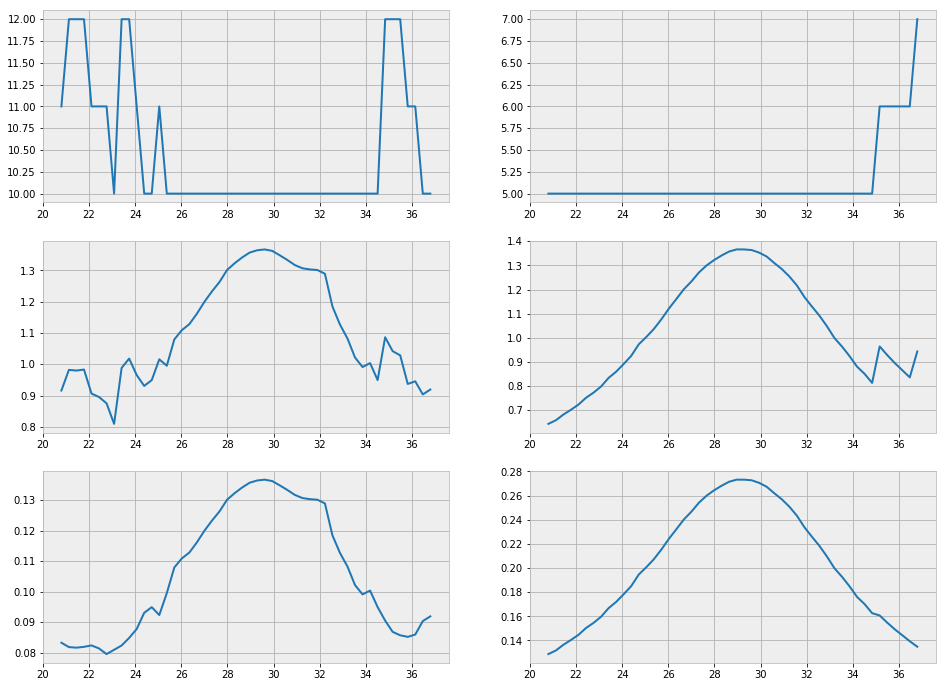

In [18]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

x_scores = x_total_intensity/x_N_maxima
y_scores = y_total_intensity/y_N_maxima

for i in range(len(angle_guesses)):
    
    print("Angle = {}".format(angle_guesses[i]))
    angles = np.linspace(angle_guesses[i]-window_rad_degrees,angle_guesses[i]+window_rad_degrees,N_rotations)
    
    fig,((ax11,ax12),(ax21,ax22),(ax31,ax32))=plt.subplots(3,2,figsize=(16,12))
    ax11.plot(angles,x_N_maxima[:,i])
    ax21.plot(angles,x_total_intensity[:,i])
    ax31.plot(angles,x_scores[:,i])
    ax12.plot(angles,y_N_maxima[:,i])
    ax22.plot(angles,y_total_intensity[:,i])
    ax32.plot(angles,y_scores[:,i])
    plt.show()

In [19]:
# Get maxima of scores

sigma = 2
min_diff = 5

x_scores = x_total_intensity/x_N_maxima
y_scores = y_total_intensity/y_N_maxima

x_scores_blurred = np.empty_like(x_scores)
y_scores_blurred = np.empty_like(y_scores)

coordinates = [('angle',float),('intensity',float)]
x_maxima = [PointList(coordinates, dc), PointList(coordinates, dc), PointList(coordinates, dc)]
y_maxima = [PointList(coordinates, dc), PointList(coordinates, dc), PointList(coordinates, dc)]

for j in range(len(angle_guesses)):

    angle_guess = angle_guesses[j]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)
    
    x_scores_blurred[:,j] = gaussian_filter(x_scores[:,j],sigma)
    y_scores_blurred[:,j] = gaussian_filter(y_scores[:,j],sigma)

    x_maxima0 = (x_scores_blurred[:,j] > np.roll(x_scores_blurred[:,j],-1)) & (x_scores_blurred[:,j] >= np.roll(x_scores_blurred[:,j],+1))
    y_maxima0 = (y_scores_blurred[:,j] > np.roll(y_scores_blurred[:,j],-1)) & (y_scores_blurred[:,j] >= np.roll(y_scores_blurred[:,j],+1))

    for i in x_maxima0.nonzero()[0]:
        new_point = (angles[i], x_scores_blurred[i,j])
        x_maxima[j].add_point(new_point)
    for i in y_maxima0.nonzero()[0]:
        new_point = (angles[i], y_scores_blurred[i,j])
        y_maxima[j].add_point(new_point)

    x_maxima[j].sort('intensity')
    y_maxima[j].sort('intensity')

    x_deletemask = np.zeros(x_maxima[j].length,dtype=bool)
    for i in range(x_maxima[j].length):
        if not x_deletemask[i]:
            delete = np.abs(x_maxima[j].data['angle'][i]-x_maxima[j].data['angle']) < min_diff
            delete[:i+1]=False
            x_deletemask = x_deletemask | delete
    x_maxima[j].remove_points(x_deletemask)

    y_deletemask = np.zeros(y_maxima[j].length,dtype=bool)
    for i in range(y_maxima[j].length):
        if not y_deletemask[i]:
            delete = np.abs(y_maxima[j].data['angle'][i]-y_maxima[j].data['angle']) < min_diff
            delete[:i+1]=False
            y_deletemask = y_deletemask | delete
    y_maxima[j].remove_points(y_deletemask)

Angle = 117.0


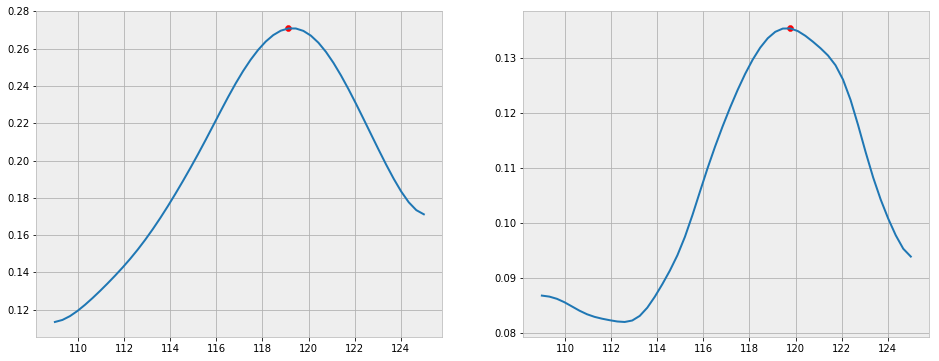

Angle = 0.0


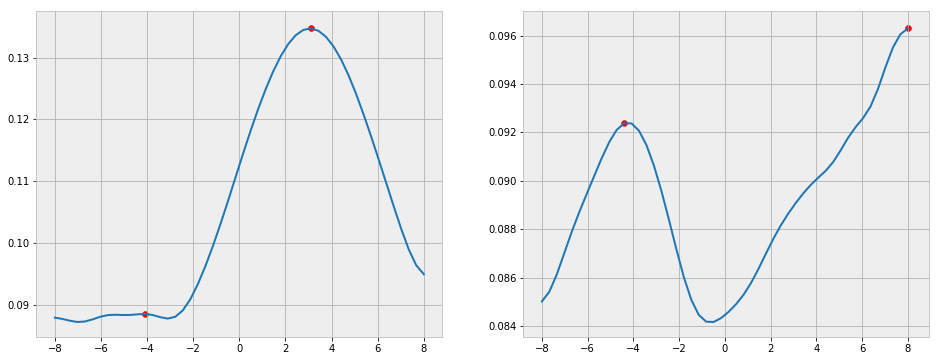

Angle = 28.8


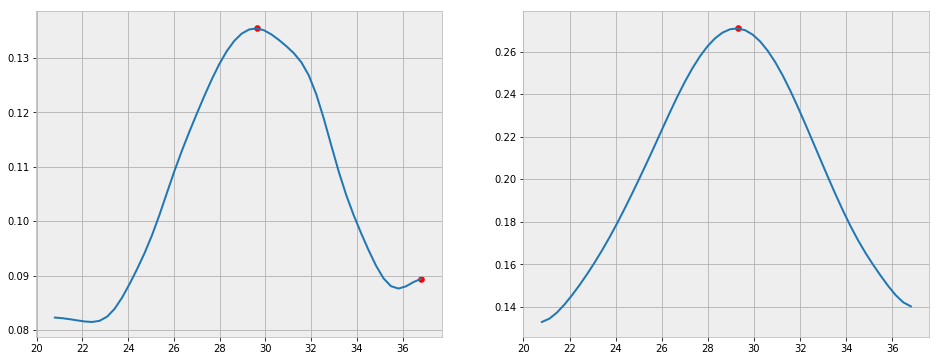

In [20]:
# Plot score and maxima

for j in range(len(angle_guesses)):

    angle_guess = angle_guesses[j]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)

    print("Angle = {}".format(angle_guess))
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
    ax1.plot(angles, x_scores_blurred[:,j])
    ax1.scatter(x_maxima[j].data['angle'],x_maxima[j].data['intensity'],color='r')
    ax2.plot(angles, y_scores_blurred[:,j])
    ax2.scatter(y_maxima[j].data['angle'],y_maxima[j].data['intensity'],color='r')
    plt.show()

### Get lattice vectors

In [21]:
# Get two principle lattice vector angles

maxima = np.array([x_maxima[i].data['intensity'][0] for i in range(len(x_maxima))])
u_index = np.argmax(maxima)
maxima[u_index]=-1000000
v_index = np.argmax(maxima)

u_angle = x_maxima[u_index].data['angle'][0]
v_angle = x_maxima[v_index].data['angle'][0]

print("u and v angles are {} and {} degrees, respectively.".format(u_angle, v_angle))

u and v angles are 119.12244897959184 and 29.61632653061224 degrees, respectively.


In [22]:
# Parameters

sigma_gaussianblur = 10
min_dist = 10
threshhold = 0.05

coordinates = [('bin',float),('intensity',float)]
u_x_maxima = PointList(coordinates, dc)
u_y_maxima = PointList(coordinates, dc)
v_x_maxima = PointList(coordinates, dc)
v_y_maxima = PointList(coordinates, dc)

In [23]:
# Get peaks when projecting down u

Bragg_peaks_rotating = Bragg_peaks_current_DP.deepcopy()
theta = u_angle*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)
for i in range(Bragg_peaks_rotating.length):
    x0 = Bragg_peaks_rotating.data['qx'][i]
    y0 = Bragg_peaks_rotating.data['qy'][i]
    Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
# Get projected histogram
bins_x = np.arange(-dc.Q_Nx,dc.Q_Nx)
bins_y = np.arange(-dc.Q_Nx,dc.Q_Ny)
x_projected_histogram = np.zeros_like(bins_x)
y_projected_histogram = np.zeros_like(bins_y)
for i in range(Bragg_peaks_rotating.length):
    x_projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
    y_projected_histogram[int(Bragg_peaks_rotating.data['qy'][i])] += 1

x_histogram_blurred = gaussian_filter(x_projected_histogram.astype(float),sigma_gaussianblur)
y_histogram_blurred = gaussian_filter(y_projected_histogram.astype(float),sigma_gaussianblur)

# Get maxima
x_maxima0 = (x_histogram_blurred > np.roll(x_histogram_blurred,-1)) & (x_histogram_blurred >= np.roll(x_histogram_blurred,+1))
y_maxima0 = (y_histogram_blurred > np.roll(y_histogram_blurred,-1)) & (y_histogram_blurred >= np.roll(y_histogram_blurred,+1))

for i in x_maxima0.nonzero()[0]:
    new_point = (bins_x[i], x_histogram_blurred[i])
    u_x_maxima.add_point(new_point)
for i in y_maxima0.nonzero()[0]:
    new_point = (bins_y[i], y_histogram_blurred[i])
    u_y_maxima.add_point(new_point)

u_x_maxima.sort('intensity')
u_y_maxima.sort('intensity')

# Remove maxima below threshhold
max_intensity = u_x_maxima.data['intensity'][0]
x_deletemask = np.zeros(u_x_maxima.length,dtype=bool)
for i in range(u_x_maxima.length):
    if u_x_maxima.data['intensity'][i]/max_intensity < threshhold:
        x_deletemask[i] = True
u_x_maxima.remove_points(x_deletemask)

max_intensity = u_y_maxima.data['intensity'][0]
y_deletemask = np.zeros(u_y_maxima.length,dtype=bool)
for i in range(u_y_maxima.length):
    if u_y_maxima.data['intensity'][i]/max_intensity < threshhold:
        y_deletemask[i] = True
u_y_maxima.remove_points(y_deletemask)

# Remove maxima which are too close together
x_deletemask = np.zeros(u_x_maxima.length,dtype=bool)
for i in range(u_x_maxima.length):
    if not x_deletemask[i]:
        delete = np.abs(u_x_maxima.data['bin'][i]-u_x_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        x_deletemask = x_deletemask | delete
u_x_maxima.remove_points(x_deletemask)

y_deletemask = np.zeros(u_y_maxima.length,dtype=bool)
for i in range(u_y_maxima.length):
    if not y_deletemask[i]:
        delete = np.abs(u_y_maxima.data['bin'][i]-u_y_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        y_deletemask = y_deletemask | delete
u_y_maxima.remove_points(y_deletemask)

In [71]:
# Get u spacing

thresh=1.5

u_y_maxima.sort('bin')
diffs = u_y_maxima.data['bin'][:-1]-u_y_maxima.data['bin'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
u_spacing = np.average(diffs)

In [25]:
# Get peaks when projecting down v

Bragg_peaks_rotating = Bragg_peaks_current_DP.deepcopy()
theta = v_angle*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)
for i in range(Bragg_peaks_rotating.length):
    x0 = Bragg_peaks_rotating.data['qx'][i]
    y0 = Bragg_peaks_rotating.data['qy'][i]
    Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
# Get projected histogram
bins_x = np.arange(-dc.Q_Nx,dc.Q_Nx)
bins_y = np.arange(-dc.Q_Nx,dc.Q_Ny)
x_projected_histogram = np.zeros_like(bins_x)
y_projected_histogram = np.zeros_like(bins_y)
for i in range(Bragg_peaks_rotating.length):
    x_projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
    y_projected_histogram[int(Bragg_peaks_rotating.data['qy'][i])] += 1

x_histogram_blurred = gaussian_filter(x_projected_histogram.astype(float),sigma_gaussianblur)
y_histogram_blurred = gaussian_filter(y_projected_histogram.astype(float),sigma_gaussianblur)

# Get maxima
x_maxima0 = (x_histogram_blurred > np.roll(x_histogram_blurred,-1)) & (x_histogram_blurred >= np.roll(x_histogram_blurred,+1))
y_maxima0 = (y_histogram_blurred > np.roll(y_histogram_blurred,-1)) & (y_histogram_blurred >= np.roll(y_histogram_blurred,+1))

for i in x_maxima0.nonzero()[0]:
    new_point = (bins_x[i], x_histogram_blurred[i])
    v_x_maxima.add_point(new_point)
for i in y_maxima0.nonzero()[0]:
    new_point = (bins_y[i], y_histogram_blurred[i])
    v_y_maxima.add_point(new_point)

v_x_maxima.sort('intensity')
v_y_maxima.sort('intensity')

# Remove maxima below threshhold
max_intensity = v_x_maxima.data['intensity'][0]
x_deletemask = np.zeros(v_x_maxima.length,dtype=bool)
for i in range(v_x_maxima.length):
    if v_x_maxima.data['intensity'][i]/max_intensity < threshhold:
        x_deletemask[i] = True
v_x_maxima.remove_points(x_deletemask)

max_intensity = v_y_maxima.data['intensity'][0]
y_deletemask = np.zeros(v_y_maxima.length,dtype=bool)
for i in range(v_y_maxima.length):
    if v_y_maxima.data['intensity'][i]/max_intensity < threshhold:
        y_deletemask[i] = True
v_y_maxima.remove_points(y_deletemask)

# Remove maxima which are too close together
x_deletemask = np.zeros(v_x_maxima.length,dtype=bool)
for i in range(v_x_maxima.length):
    if not x_deletemask[i]:
        delete = np.abs(v_x_maxima.data['bin'][i]-v_x_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        x_deletemask = x_deletemask | delete
v_x_maxima.remove_points(x_deletemask)

y_deletemask = np.zeros(v_y_maxima.length,dtype=bool)
for i in range(v_y_maxima.length):
    if not y_deletemask[i]:
        delete = np.abs(v_y_maxima.data['bin'][i]-v_y_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        y_deletemask = y_deletemask | delete
v_y_maxima.remove_points(y_deletemask)

In [79]:
# Get v spacing

thresh_stds = 2

v_y_maxima.sort('bin')
diffs = v_y_maxima.data['bin'][:-1]-v_y_maxima.data['bin'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
v_spacing = np.average(diffs)

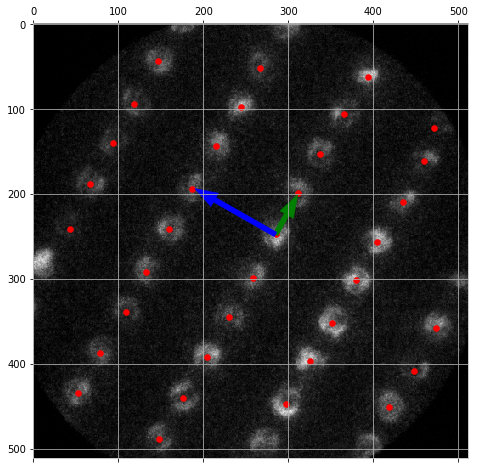

In [108]:
# Show

ind = np.argmin((Bragg_peaks_current_DP.data['qx']-dc.Q_Nx/2)**2 + (Bragg_peaks_current_DP.data['qy']-dc.Q_Ny/2)**2)
x0,y0 = Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

u_dx = np.cos(u_angle*np.pi/180.)*u_spacing
u_dy = np.sin(u_angle*np.pi/180.)*u_spacing
v_dx = np.cos(v_angle*np.pi/180.)*v_spacing
v_dy = np.sin(v_angle*np.pi/180.)*v_spacing

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,-u_dx,-u_dy, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,-v_dx,-v_dy, color='b',width=6,length_includes_head=True)
plt.show()

### Save lattice vectors

In [60]:
# Save

savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
py4DSTEM.readwrite.save_dataobject(Bragg_peak_point_list,savepath)

Creating file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5...
Writing metadata...
Done.
